In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycraf
import cysgp4
import astropy.coordinates as coord
from pycraf import conversions as cnv
from pycraf import protection, antenna, geometry,satellite
from astropy import units as u, constants as const

from scepter import skynet,obs
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
from matplotlib.gridspec import GridSpec
from matplotlib import animation

## This is a short pipeline to load the tles and visulise location of source to dynamic spectrum

In [2]:
### Cas A source in skycoord
casA=SkyCoord.from_name('Cas A')

#### OTT1
#  geographic longitude: 	 11° 55′ 11″
#  geographic latitude: 	 57° 23′ 37″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°

#### OTT2
#  geographic longitude: 	 11° 55′ 08″
#  geographic latitude: 	 57° 23′ 35″
#  altitude above sea level: 	 16 m
#  diameter of telescope: 	 13.2 m
#  minimum elevation: 	  0°


longitude = coord.Angle("11d55m11s").deg
latitude = coord.Angle("+57d23m37s").deg
elevation = 16 * u.m
ott1=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

longitude = coord.Angle("11d55m08s").deg
latitude = coord.Angle("+57d23m35s").deg
elevation = 16 * u.m
ott2=cysgp4.PyObserver(longitude,latitude,elevation.to(u.km).value)

observatories=np.array([ott1,ott2])
observatories=observatories[:,np.newaxis,np.newaxis]   

#### telescopes are first in the 3d array, then tles, then time

def altaz_transformer(observatory,observing_time,source):
    observing_location = EarthLocation(lat=observatory.loc.lat, lon=observatory.loc.lon, height=observatory.loc.alt)
    aa = AltAz(location=observing_location, obstime=observing_time)
    newaa=source.transform_to(aa)
    return newaa

casAnew=altaz_transformer(ott1,Time.now(),casA)

print(casAnew.alt,casAnew.az)

29d38m41.09345065s 20d02m02.34313786s


### load tles

In [3]:
tle_filedir='./tles_npzs_starlink/'
tlefile='20240429_120941.npz'
tles=np.load(tle_filedir+tlefile,allow_pickle=True)

response=tles['arr_0']
tle_string=response.item().text
# print(tle_string)
tles=np.array(cysgp4.tles_from_text(tle_string))


### satellites are in the form of [telescope, n_satellites,mjd]?
tles=tles[np.newaxis,:,np.newaxis]

tle_filedir2='./tles_npzs_oneweb/'
tlefile2='20240429_121643.npz'
tles2=np.load(tle_filedir2+tlefile2,allow_pickle=True)

response2=tles2['arr_0']
tle_string2=response2.item().text
# print(tle_string)
tles2=np.array(cysgp4.tles_from_text(tle_string2))


### satellites are in the form of [telescope, n_satellites,mjd]v
tles2=tles2[np.newaxis,:,np.newaxis]


#### load spectrum data

In [4]:
dateline='2024-04-29T12_37_15'
pol='I' ## XX,YY,XY or I/Q/U/V
data_file=np.load(f'./npdata/dataset_Correlator_{pol}_ottCorrDataMonitoring10700MHzPolH-{dateline}.npz')

tlabel='corr_I'
# data_file.keys will show the keys in the file,
# data, telescope_az, telescope_el, f_GHz, mjd
data, telescope_az, telescope_el = data_file['data'], data_file['telescope_az'], data_file['telescope_el']
f_GHz, mjd = data_file['f_GHz'], data_file['mjd']

#### telescopes are first in the 3d array, then tles, then time

mjds=mjd[np.newaxis,np.newaxis,:]

print (mjds.shape,mjd.shape)

(1, 1, 41908) (41908,)


### plot data

data size: (41908, 513), channels:(513,)
fmin: 10.7, fmax: 12.7


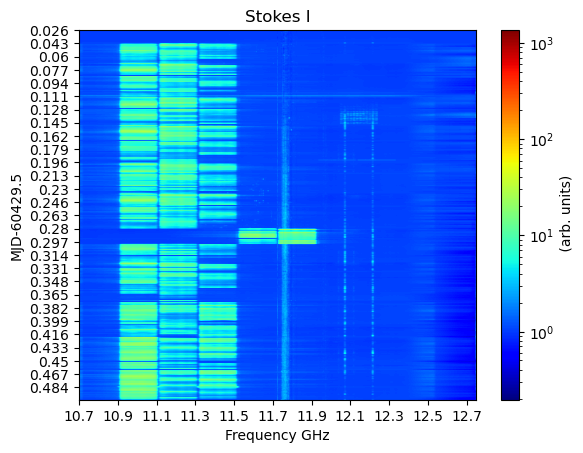

In [5]:
import matplotlib.colors as colors
# stokesI = (dataxx + datayy)/2
stokesI = data[:,:]
print(f"data size: {data.shape}, channels:{f_GHz.shape}")
print(f"fmin: {f_GHz.min()}, fmax: {f_GHz.max()}")
### frequency boundary here
fmin=9
fmax=14.1

#### tweak label steps here
ystep=1500
xstep=50

## apply bandpass correction and dB conversion here if needed
# stokesI=10*np.log10(stokesI)### convert to dB
bandpass=np.mean(stokesI[:100,:],axis=0)
stokesI = stokesI/bandpass


### make plot
plt.title('Stokes I')
plt.imshow(stokesI, aspect='auto', cmap='jet', norm=colors.LogNorm(vmin=stokesI.min(), vmax=stokesI.max()))
plt.colorbar(label=' (arb. units)')
plt.xlabel('Frequency GHz')
plt.xticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
plt.ylabel(f"MJD-{np.round(mjd[0],1)}")
plt.yticks(np.arange(0, data.shape[0], ystep), np.round(mjd[::ystep]-np.round(mjd[0],1),3))
plt.xlim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
plt.show()

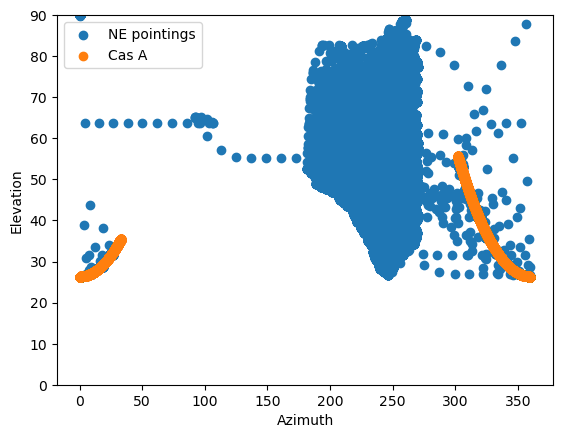

In [6]:
### not really useful plot to show satellite tracks.
casAnew=altaz_transformer(ott1,Time(mjd,format='mjd'),casA)
# plt.plot(topo_pos_az[0,0,:],topo_pos_el[0,0,:],label='satellites OTT1 location')
# plt.scatter(topo_pos_az[1,:,:],topo_pos_el[1,:,:],label='OTT2')
plt.scatter(telescope_az,telescope_el,label='NE pointings')
plt.scatter(casAnew.az.deg,casAnew.alt.deg,label='Cas A')
plt.xlabel('Azimuth')
plt.ylabel('Elevation')
plt.ylim(0,90)
plt.legend()
plt.show()

### determine transit times and onsource positions

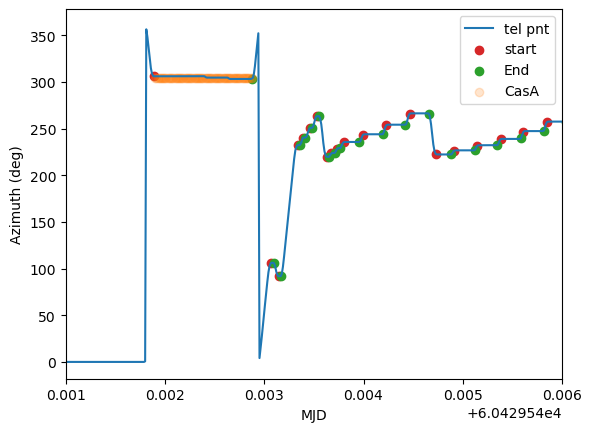

In [7]:
tel_pointing=coord.SkyCoord(telescope_az,telescope_el,unit='deg')
casA_pointing=coord.SkyCoord(casAnew.az,casAnew.alt,unit='deg')
onsource_mask=np.append(True,np.abs(np.diff(telescope_el))<1)*np.append(False,np.abs(np.diff(telescope_az))<1)
casA_mask=tel_pointing.separation(casA_pointing)<1*u.deg
cal_loc=np.where(casA_mask*onsource_mask)[0]


onsource_loc=np.where(onsource_mask)[0]
mask=(np.diff(onsource_loc)>1)[:]
insertvals=onsource_loc[1:][mask][:-1]-1 ### stupid way of finding the start of a transit observation
endvals=onsource_loc[:-1][mask][1:]
end_times=mjd[endvals]
start_times=mjd[insertvals]

mask_casA=(np.diff(cal_loc)>1)[:]
casA_start=cal_loc[1:][mask_casA][:-1]-1
casA_end=cal_loc[:-1][mask_casA][1:]
# print(casA_start,casA_end)

from astropy.time import Time

times=Time(mjd,format='mjd')
start_times=Time(start_times,format='mjd')
end_times=Time(end_times,format='mjd')  


onsource_loc=np.insert(onsource_loc,np.where(mask)[0][:-1],insertvals)

pnts=coord.SkyCoord(telescope_az[onsource_mask],telescope_el[onsource_mask],unit='deg',frame='altaz')

plt.plot(mjd,telescope_az,label='tel pnt')
# plt.scatter(mjd[onsource_loc],telescope_az[onsource_loc],label='on source',color='red')
plt.scatter(mjd[insertvals],telescope_az[insertvals],label='start',color='C3')
plt.scatter(mjd[endvals],telescope_az[endvals],label='End',color='C2')
plt.scatter(mjd[casA_mask],casAnew.az[casA_mask],label='CasA',color='C1',alpha=0.2)
plt.legend()
plt.ylabel('Azimuth (deg)')
plt.xlabel('MJD')
plt.xlim(60429.541,60429.546)
plt.show()

# print(pnts)

#### test operation within time cutouts for tle coordinates

In [8]:
### get time points for tle coordinates
for i,j in zip(insertvals[:10],endvals[:10]):
    ### data prep
    cutout=stokesI[i:j,:]
    mid=np.argmax(np.sum(cutout,axis=1))
    cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
    cutout_coords=coord.SkyCoord(telescope_az[mid],telescope_el[mid],unit='deg')
    print(f'loading tles for {np.round(mjd[j],5)} to {np.round(mjd[j],5)}',end="\r")
    sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    
    topo_pos = sat_info['topo']
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
    topo_pos2 = sat_info2['topo']
    topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))
    
    # print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
    satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
    satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')
    
    dist=cutout_coords.separation(satellite_coords)
    dist2=cutout_coords.separation(satellite_coords2)
    # print('satellite coord shape',satellite_coords.shape,dist.shape)
    closest_sat=np.argmin(dist)
    closest_sat2=np.argmin(dist2)
    # print(closest_sat,dist[closest_sat])
    bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
    beamsep=cutout_coords.separation(bestsat_coord)
    bestsatname=tles[0,closest_sat,0].int_designator
    bestsatname=bestsatname.decode('utf-8')

    bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
    beamsep2=cutout_coords.separation(bestsat_coord2)
    bestsatname2=tles2[0,closest_sat2,0].int_designator
    bestsatname2=bestsatname2.decode('utf-8')
    if dist[closest_sat]>10*u.deg:
        if dist2[closest_sat2]>10*u.deg:
            print('oneweb satellite is also too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat2]}")
        else:
            print('starlink satellite is too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")



oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 21090AE , closest distance is 24.99777970732059 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23043AJ , closest distance is 25.707197008377918 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23043AJ , closest distance is 25.56047199236898 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 24.737518214911454 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 24.233990593182895 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 23.738968258445773 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23029C  , closest distance is 23.419823483235657 deg
oneweb satellit

#### generate all tle positions,may take a while

In [9]:
# # print(observatories,tles.shape,mjds.shape)
# sat_info=cysgp4.propagate_many(mjds,tles,observers=observatories,
# do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
# print('constellation 1 loaded')
# # print(observatories,tles.shape,mjds.shape)
# sat_info2=cysgp4.propagate_many(mjds,tles2,observers=observatories,
# do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
# print('constellation 2 loaded')


#### get topo positions

In [10]:
# topo_pos = sat_info['topo']
# # sat_azel = sat_info['sat_azel']  ### check cysgp4 for satellite frame orientation description

# # eci_pos_x, eci_pos_y, eci_pos_z = (eci_pos[..., i] for i in range(3))
# topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., i] for i in range(4))
# # obs_az, obs_el, obs_dist = (sat_azel[..., i] for i in range(3))

# topo_pos2 = sat_info2['topo']
# topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., i] for i in range(4))



### preview CasA pointings dynamic spectrum

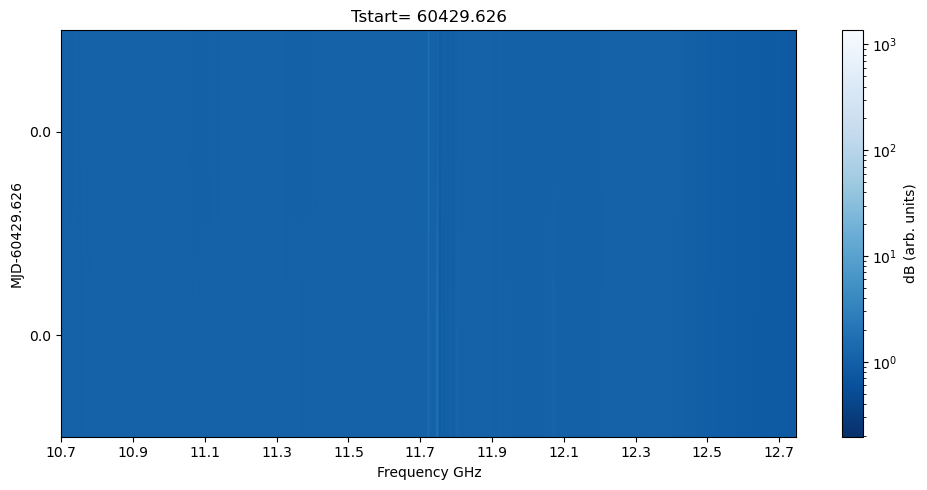

In [11]:
### xstep and ystep to get the desired number of ticks on the plot
xstep=50
ystep=10000
### frequency range to plot, bigger than 10-13 GHz to plot whole
fmin=9.9
fmax=13.5
### snapshot label name here

for i,j in zip(casA_start[4:5],casA_end[4:5]):
    cutout=stokesI[i:j,:]
    plt.figure(figsize=(10,5))
    plt.title(f'Tstart= {np.round(mjd[i],3)}')
    plt.imshow(cutout, aspect='auto', cmap='Blues_r', norm=colors.LogNorm(vmin=stokesI.min(), vmax=stokesI.max()))
    plt.colorbar(label='dB (arb. units)')
    plt.xlabel('Frequency GHz')
    plt.xticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
    plt.ylabel(f"MJD-{np.round(mjd[i],3)}")
    yticks=np.round(mjd[i:j]-mjd[i],4)
    plt.yticks(np.arange(j-i), yticks)
    plt.xlim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
    plt.tight_layout()
    # plt.savefig(figsave_dir+tlabel+f'sat_scan_{np.round(mjd[i],3)}.png')    
    
    plt.show()
#     plt.close()

#### preview dynamic spectrum plotting

starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 20019BM , closest distance is 25.10667027349336 deg


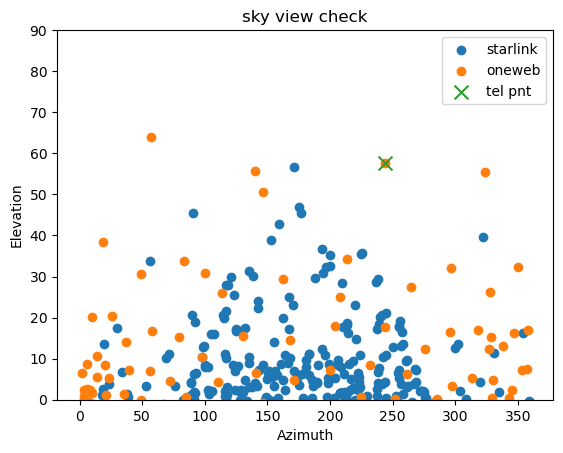

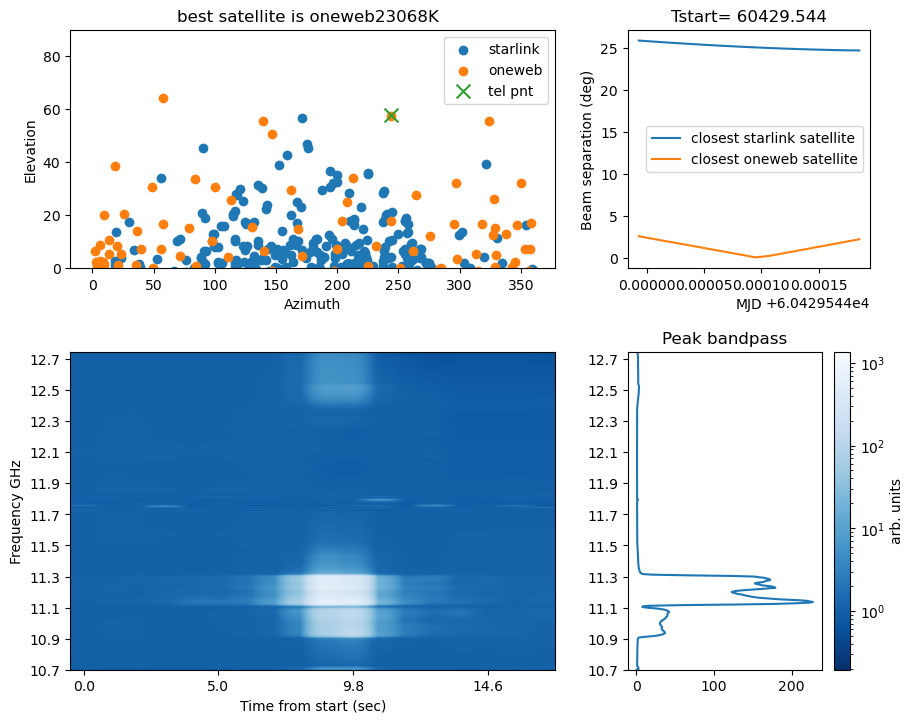

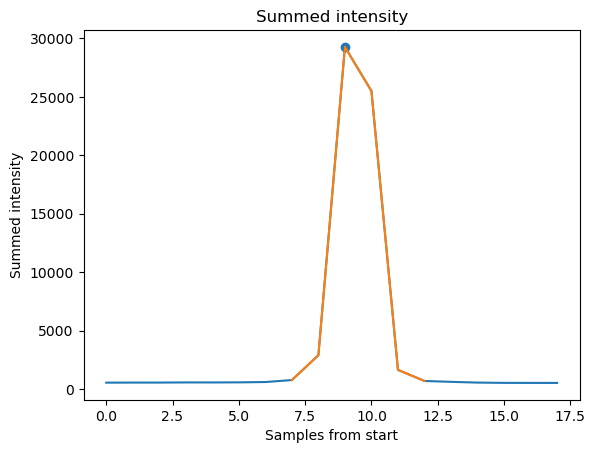

In [14]:
i=insertvals[11]
j=endvals[11]

### data prep
cutout=stokesI[i:j,:]
mid=np.argmax(np.sum(cutout,axis=1))
cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
cutout_coords=coord.SkyCoord(telescope_az[mid+i],telescope_el[mid+i],unit='deg')
print(f'loading tles for {np.round(mjd[i],5)} to {np.round(mjd[j],5)}',end="\r")


sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
        do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
        do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 

topo_pos = sat_info['topo']
topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
topo_pos2 = sat_info2['topo']
topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))

# print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')

dist=cutout_coords.separation(satellite_coords)
dist2=cutout_coords.separation(satellite_coords2)
# print('satellite coord shape',satellite_coords.shape,dist.shape)
closest_sat=np.argmin(dist)
closest_sat2=np.argmin(dist2)
# print(closest_sat,dist[closest_sat])
bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
beamsep=cutout_coords.separation(bestsat_coord)
bestsatname=tles[0,closest_sat,0].int_designator
bestsatname=bestsatname.decode('utf-8')

bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
beamsep2=cutout_coords.separation(bestsat_coord2)
bestsatname2=tles2[0,closest_sat2,0].int_designator
bestsatname2=bestsatname2.decode('utf-8')

if dist[closest_sat]>10*u.deg:
        if dist2[closest_sat2]>10*u.deg:
                print('oneweb satellite is also too far away > 10 degrees, check the data')
                print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat]}")
        else:
                print('starlink satellite is too far away > 10 degrees, check the data')
                print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")
if beamsep[0]<beamsep2[0]:
        bestmatch='starlink'+bestsatname
else:
        bestmatch='oneweb'+bestsatname2

peak=np.where(np.sum(cutout,axis=1)>np.percentile(np.sum(cutout,axis=1),68))
mjdticks_insec=np.round((mjd[i:j]-mjd[i])*24*3600,2)
timestep=5
tick_intv=np.arange(0,j-i,timestep)

### sky view check
plt.title('sky view check')
# plt.plot(topo_pos_az[0,closest_sat,i:j],topo_pos_el[0,closest_sat,i:j],label='satellite')
# plt.plot(telescope_az[i:j],telescope_el[i:j],label='tel pnt')
plt.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
plt.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')

plt.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
plt.ylim(0,90)
plt.xlabel('Azimuth')
plt.ylabel('Elevation')
plt.legend()
plt.show()




#### main figure
fig=plt.figure(figsize=(10,8))
gs = GridSpec(2,2,width_ratios=(4, 2), height_ratios=(3, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1],sharey=ax3)
ax2.set_title(f'Tstart= {np.round(mjd[i],3)}')



### ax1 satellite track and telescope pointing
ax1.set_title(f'best satellite is {bestmatch}')
ax1.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
ax1.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')
ax1.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
ax1.set_xlabel('Azimuth')
ax1.set_ylabel('Elevation')
ax1.set_ylim(0,90)

ax1.legend()

### ax2 time evolution, multiple info, 

ax2.plot(mjd[i:j],beamsep,label='closest starlink satellite')
ax2.plot(mjd[i:j],beamsep2,label='closest oneweb satellite')

ax2.set_ylabel('Beam separation (deg)')
ax2.set_xlabel('MJD')
# ax2.set_xticks(np.arange(j-i), mjdticks)
ax2.legend()


####ax3 is the dynamic spectrum
img=ax3.imshow(cutout.T, aspect='auto', cmap='Blues_r', norm=colors.LogNorm(vmin=stokesI.min(), vmax=stokesI.max()))

ax3.set_ylabel('Frequency GHz')
ax3.set_yticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
# plt.ylabel(f"MJD-{np.round(mjd[i],3)}")
ax3.set_xlabel(f"Time from start (sec)")
ax3.set_xticks(tick_intv, mjdticks_insec[tick_intv])
ax3.set_ylim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
cbar=fig.colorbar(img,ax=ax4)
cbar.set_label(label='arb. units')

### ax4 frequency bandpass at peak
ax4.set_title('Peak bandpass')
ax4.plot(np.mean(cutout[peak[0],:],axis=0),np.arange(cutout.shape[1]))





#### show
plt.show()


## just to doublecheck I'm capturing the right time
plt.title('Summed intensity')
plt.plot(np.sum(cutout,axis=1))
plt.plot(peak[0],np.sum(cutout,axis=1)[peak[0]])
plt.scatter(mid,np.sum(cutout,axis=1)[mid])
plt.xlabel('Samples from start')
plt.ylabel('Summed intensity')
plt.show()
# plt.close()

In [13]:
figsave_dir='./snapshots/'
### directory to save the cutouts
### xstep and ystep to get the desired number of ticks on the plot
xstep=50
ystep=10000
### frequency range to plot, bigger than 10-13 GHz to plot whole
fmin=9.9
fmax=13.5
### snapshot label name here
tlabel='corr_I'

for i,j in zip(insertvals,endvals):
    ### data prep
    cutout=stokesI[i:j,:]
    mid=np.argmax(np.sum(cutout,axis=1))
    cutout_mjd=mjds[:,:,i:j] ### satellite arrays are in the form of [telescope, n_satellites,mjd]
    cutout_coords=coord.SkyCoord(telescope_az[mid+i],telescope_el[mid+i],unit='deg')
    print(f'loading tles for {np.round(mjd[i],5)} to {np.round(mjd[j],5)}',end="\r")


    sat_info=cysgp4.propagate_many(cutout_mjd,tles,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 
    sat_info2=cysgp4.propagate_many(cutout_mjd,tles2,observers=observatories[0],
            do_eci_pos=False, do_topo=True, do_obs_pos=False, do_sat_azel=False,sat_frame='zxy') 

    topo_pos = sat_info['topo']
    topo_pos_az, topo_pos_el, topo_pos_dist, _ = (topo_pos[..., idx] for idx in range(4))
    topo_pos2 = sat_info2['topo']
    topo_pos_az2, topo_pos_el2, topo_pos_dist2, _ = (topo_pos2[..., idx] for idx in range(4))

    # print(f"length is {j-i}, peak length is {len(peak)}, tle coord array shape is{topo_pos_az2.shape}")
    satellite_coords=coord.SkyCoord(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],unit='deg')
    satellite_coords2=coord.SkyCoord(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],unit='deg')

    dist=cutout_coords.separation(satellite_coords)
    dist2=cutout_coords.separation(satellite_coords2)
    # print('satellite coord shape',satellite_coords.shape,dist.shape)
    closest_sat=np.argmin(dist)
    closest_sat2=np.argmin(dist2)
    # print(closest_sat,dist[closest_sat])
    bestsat_coord=coord.SkyCoord(topo_pos_az[0,closest_sat,:],topo_pos_el[0,closest_sat,:],unit='deg')
    beamsep=cutout_coords.separation(bestsat_coord)
    bestsatname=tles[0,closest_sat,0].int_designator
    bestsatname=bestsatname.decode('utf-8')

    bestsat_coord2=coord.SkyCoord(topo_pos_az2[0,closest_sat2,:],topo_pos_el2[0,closest_sat2,:],unit='deg')
    beamsep2=cutout_coords.separation(bestsat_coord2)
    bestsatname2=tles2[0,closest_sat2,0].int_designator
    bestsatname2=bestsatname2.decode('utf-8')
 
    if dist[closest_sat]>10*u.deg:
        if dist2[closest_sat2]>10*u.deg:
            print('oneweb satellite is also too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname2}, closest distance is {dist2[closest_sat2]}")
        else:
            print('starlink satellite is too far away > 10 degrees, check the data')
            print(f"closest sateliite is {bestsatname}, closest distance is {dist[closest_sat]}")
    if beamsep[0]<beamsep2[0]:
        bestmatch='starlink'+bestsatname
    else:
        bestmatch='oneweb'+bestsatname2

    peak=np.where(np.sum(cutout,axis=1)>np.percentile(np.sum(cutout,axis=1),68))
    mjdticks_insec=np.round((mjd[i:j]-mjd[i])*24*3600,2)
    timestep=5
    tick_intv=np.arange(0,j-i,timestep)
    spectra=np.mean(cutout[peak[0],:],axis=0)
    #### main figure
    fig=plt.figure(figsize=(10,8))
    gs = GridSpec(2,2,width_ratios=(4, 3), height_ratios=(3, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.2, hspace=0.3)
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,0])
    ax4 = plt.subplot(gs[1,1],sharey=ax3)
    ax2.set_title(f'Tstart= {np.round(mjd[i],3)}')



    ### ax1 satellite track and telescope pointing
    ax1.set_title(f'best satellite is {bestmatch}')
    ax1.scatter(topo_pos_az[0,:,mid],topo_pos_el[0,:,mid],label='starlink')
    ax1.scatter(topo_pos_az2[0,:,mid],topo_pos_el2[0,:,mid],label='oneweb')
    ax1.scatter(telescope_az[mid+i],telescope_el[mid+i],label='tel pnt',s=100,marker='x' )
    ax1.set_xlabel('Azimuth')
    ax1.set_ylabel('Elevation')
    ax1.set_ylim(0,90)

    ax1.legend()

    ### ax2 time evolution, multiple info, 
    
    ax2.plot(mjd[i:j],beamsep,label='closest starlink satellite')
    ax2.plot(mjd[i:j],beamsep2,label='closest oneweb satellite')

    ax2.set_ylabel('Beam separation (deg)')
    ax2.set_xlabel('MJD')
    # ax2.set_xticks(np.arange(j-i), mjdticks)
    ax2.legend()


    ####ax3 is the dynamic spectrum
    img=ax3.imshow(cutout.T, aspect='auto', cmap='Blues_r', norm=colors.LogNorm(vmin=stokesI.min(), vmax=stokesI.max()))

    ax3.set_ylabel('Frequency GHz')
    ax3.set_yticks(np.arange(0, data.shape[1], xstep), np.round(f_GHz[::xstep],1))
    # plt.ylabel(f"MJD-{np.round(mjd[i],3)}")
    ax3.set_xlabel(f"Time from start (sec)")
    ax3.set_xticks(tick_intv, mjdticks_insec[tick_intv])
    ax3.set_ylim(np.where(f_GHz>fmin)[0][0],np.where(f_GHz<fmax)[0][-1])
    cbar=fig.colorbar(img,ax=ax4)
    cbar.set_label(label='arb. units')

    ### ax4 frequency bandpass at peak
    ax4.set_title('Peak bandpass')
    
    ax4.plot(spectra,np.arange(spectra.shape[0]))
    ax4.set_xlabel('Intensity')
    ax4.set_xlim(1e-2,10**(np.log(spectra.max())+0.5))
    ax4.set_xscale('log')
    



    ## save show and close
    plt.savefig(figsave_dir+tlabel+f"_satscan_{np.round(mjd[i],5)}.png")        
    # plt.show()
    plt.close()

starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 23078D  , closest distance is 21.541572381256586 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23068K  , closest distance is 10.508430445865052 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23068K  , closest distance is 14.97167868801827 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23068K  , closest distance is 19.492472917565625 deg
oneweb satellite is also too far away > 10 degrees, check the data
closest sateliite is 23043AJ , closest distance is 16.006208738614422 deg
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 22083AK , closest distance is 12.92807204041396 deg
starlink satellite is too far away > 10 degrees, check the data
closest sateliite is 22053AE , closest distance is 18.28948235406297 deg
starlink satellite is too